# Code to Generate Test Cases

In [ ]:
import numpy as np
import numba
import math
import pickle
from matplotlib import pyplot as plt

In [ ]:
NUMBER_OF_TEST_CASES_PER_SCENARIO = 16
MY_SEED = 3141592653
TOLERANCE_FOR_TOTAL_WEIGHTS = 1e-4

In [ ]:
np.random.seed(MY_SEED)

In [ ]:
# N_space are the test values fot the total weight of elements in the distribution
# M_space are the test values for the number of elements in the distribution
N_space = np.logspace(3,7,num=25, dtype=np.int32)
M_space = np.logspace(1,4,num=25, dtype=np.int32)
N_space, M_space

(array([    1000,     1467,     2154,     3162,     4641,     6812,
           10000,    14677,    21544,    31622,    46415,    68129,
          100000,   146779,   215443,   316227,   464158,   681292,
         1000000,  1467799,  2154434,  3162277,  4641588,  6812920,
        10000000], dtype=int32),
 array([   10,    13,    17,    23,    31,    42,    56,    74,   100,
          133,   177,   237,   316,   421,   562,   749,  1000,  1333,
         1778,  2371,  3162,  4216,  5623,  7498, 10000], dtype=int32))

In [ ]:
# Smaller test spaces for the Naive (i.e. brute force) approaches
N_space_small = np.array([100,200,500,1000,2000,5000,10000])
M_space_small = np.array([5,10,15,20,25])

### Explanation of uniform distibution sampling technique
In general we wish to have mean weight close to $\mu = \frac{m}{n}$ with a minimum weight of $1$, and therefore a maximum weight of $t = 2\mu-1$. When sampling integers from the discrete uniform distribution we need to choose an upper bound of either $\lceil t \rceil$ or $\lfloor t \rfloor$, both of which produce total weights far from $m$ when $\frac{m}{n} \approx 1$. Instead of choosing between $\lceil t \rceil$ and $\lfloor t \rfloor$ we combine samples from both distribution in the optimum ratio, such that for the $i$th weight, $w_i$, we use

$w_i \sim \begin{cases}
					\mathrm{unif}\{1,\lfloor t \rfloor\}, \quad  & i \ge n(t - \lfloor t \rfloor ) \\
					\mathrm{unif}\{1,\lceil t \rceil\}, \quad  & i < n(t - \lfloor t \rfloor )
					\end{cases}$

In [ ]:
@numba.njit
def weights_generator_uniform(total_weight, number_of_elements):
    # Generates a test case for weights from the discrete uniform distribution
    # See note above for exact details and explanation
    mean = total_weight/number_of_elements
    top = mean * 2 - 1
    floor = math.floor(top)
    
    # Number of elements to take from unif(1, ceil(t))
    n_ceil = int((top-floor) * number_of_elements)

    # Number of elements to take from unif(1, floor(t))    
    n_floor = number_of_elements - n_ceil

    return np.concatenate((np.random.randint(1,  floor+1, n_floor),  np.random.randint(1,  floor+2, n_ceil)))

In [ ]:
@numba.njit
def weights_generator_poisson(total_weight, number_of_elements):
    # Generates samples from the poisson distribution
    # As the minumum weight is 1, each sample is actually sampled such that 
    # w - 1 ~ Poisson((N-M)/M)
    extra_needed = total_weight - number_of_elements
    mean = extra_needed / number_of_elements
    weights = np.random.poisson(mean, number_of_elements) + 1
    return weights

In [ ]:
@numba.njit
def weights_generator_geometric(total_weight, number_of_elements):
    # Generates samples from the Geometric Distribution
    return np.random.geometric(number_of_elements / total_weight, number_of_elements)

In [ ]:
weight_distributions = {'uniform': weights_generator_uniform,
                        'poisson': weights_generator_poisson,
                        'geometric': weights_generator_geometric}

In [ ]:
@numba.njit
def generate_weight_test_cases(generator, total_weight, number_of_elements, number_of_test_cases, tolerance = TOLERANCE_FOR_TOTAL_WEIGHTS):
  # Given a particular test setup, we need to generate 100 cases where the total
  # weight is very close the desired total weight. The below function will
  # repeatedly generate putative test cases and collect those with suitable total
  # weights until the desired 100 are generated.
    cases = []
    while len(cases) < number_of_test_cases:
        weights = generator(total_weight, number_of_elements)
        if abs(weights.sum() / total_weight  - 1) < tolerance:
            cases.append(weights)
    return cases

In [ ]:
# Generate weights test case and collect in a dictionary
weights_test_cases = {}
for generator_name, generator in weight_distributions.items():
    for total_weight  in N_space:
        for number_of_elements in M_space:
            if number_of_elements < total_weight:
                cases = generate_weight_test_cases(generator = generator,
                                                  total_weight = total_weight,
                                                  number_of_elements = number_of_elements, 
                                                  number_of_test_cases = NUMBER_OF_TEST_CASES_PER_SCENARIO)
                key = (generator_name, total_weight, number_of_elements)
                weights_test_cases[key] = cases
            print(key)

('uniform', 1000, 10)
('uniform', 1000, 13)
('uniform', 1000, 17)
('uniform', 1000, 23)
('uniform', 1000, 31)
('uniform', 1000, 42)
('uniform', 1000, 56)
('uniform', 1000, 74)
('uniform', 1000, 100)
('uniform', 1000, 133)
('uniform', 1000, 177)
('uniform', 1000, 237)
('uniform', 1000, 316)
('uniform', 1000, 421)
('uniform', 1000, 562)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1000, 749)
('uniform', 1467, 10)
('uniform', 1467, 13)
('uniform', 1467, 17)
('uniform', 1467, 23)
('uniform', 1467, 31)
('uniform', 1467, 42)
('uniform', 1467, 56)
('uniform', 1467, 74)
('uniform', 1467, 100)
('uniform', 1467, 133)
('uniform', 1467, 177)
('uniform', 1467, 237)
('uniform', 1467, 316)
('uniform', 1467, 421)
('uniform', 1467, 562)
('uniform', 1467, 749)
('uniform', 1467, 1000)
('uniform', 1467, 1333)
('uniform', 1467, 1333)
(

In [ ]:
# Save to disk
pickle.dump(weights_test_cases, open('/content/drive/MyDrive/MSc Project/test_cases_weights.p', "wb" ))

In [ ]:
# Generate small weights test case and collect in a dictionary
small_weights_test_cases = {}
for generator_name, generator in weight_distributions.items():
    for total_weight  in N_space_small:
        for number_of_elements in M_space_small:
            if number_of_elements < total_weight:
                cases = generate_weight_test_cases(generator = generator,
                                                  total_weight = total_weight,
                                                  number_of_elements = number_of_elements, 
                                                  number_of_test_cases = NUMBER_OF_TEST_CASES_PER_SCENARIO)
                key = (generator_name, total_weight, number_of_elements)
                small_weights_test_cases[key] = cases
            print(key)

('uniform', 100, 5)
('uniform', 100, 10)
('uniform', 100, 15)
('uniform', 100, 20)
('uniform', 100, 25)
('uniform', 200, 5)
('uniform', 200, 10)
('uniform', 200, 15)
('uniform', 200, 20)
('uniform', 200, 25)
('uniform', 500, 5)
('uniform', 500, 10)
('uniform', 500, 15)
('uniform', 500, 20)
('uniform', 500, 25)
('uniform', 1000, 5)
('uniform', 1000, 10)
('uniform', 1000, 15)
('uniform', 1000, 20)
('uniform', 1000, 25)
('uniform', 2000, 5)
('uniform', 2000, 10)
('uniform', 2000, 15)
('uniform', 2000, 20)
('uniform', 2000, 25)
('uniform', 5000, 5)
('uniform', 5000, 10)
('uniform', 5000, 15)
('uniform', 5000, 20)
('uniform', 5000, 25)
('uniform', 10000, 5)
('uniform', 10000, 10)
('uniform', 10000, 15)
('uniform', 10000, 20)
('uniform', 10000, 25)
('poisson', 100, 5)
('poisson', 100, 10)
('poisson', 100, 15)
('poisson', 100, 20)
('poisson', 100, 25)
('poisson', 200, 5)
('poisson', 200, 10)
('poisson', 200, 15)
('poisson', 200, 20)
('poisson', 200, 25)
('poisson', 500, 5)
('poisson', 500, 10

In [ ]:
# Save to disk
pickle.dump(small_weights_test_cases, open('/content/drive/MyDrive/MSc Project/test_cases_weights_small.p', "wb" ))

In [ ]:
# Three probability distributions to sample the event success probabilities from
probability_distributions = {'uniform': np.random.random,
                             'near_0': lambda n: np.random.beta(a=0.5, b=5.0,size=n),
                             'near_1': lambda n: np.random.beta(a=5.0, b=0.5, size=n)
                            }

In [ ]:
# Generate test probabilities, ensuring that no probabilities are 1 or 0
probabilities_test_cases = {}
for generator_name, generator in probability_distributions.items():
      for number_of_elements in M_space:
          cases = []
          while len(cases) <= NUMBER_OF_TEST_CASES_PER_SCENARIO:
              case = generator(number_of_elements)
              if not (1.0 in case or 0.0 in case):
                  cases.append(case)
          key = (generator_name, number_of_elements)
          probabilities_test_cases[key] = cases
          print(key)

('uniform', 10)
('uniform', 13)
('uniform', 17)
('uniform', 23)
('uniform', 31)
('uniform', 42)
('uniform', 56)
('uniform', 74)
('uniform', 100)
('uniform', 133)
('uniform', 177)
('uniform', 237)
('uniform', 316)
('uniform', 421)
('uniform', 562)
('uniform', 749)
('uniform', 1000)
('uniform', 1333)
('uniform', 1778)
('uniform', 2371)
('uniform', 3162)
('uniform', 4216)
('uniform', 5623)
('uniform', 7498)
('uniform', 10000)
('near_0', 10)
('near_0', 13)
('near_0', 17)
('near_0', 23)
('near_0', 31)
('near_0', 42)
('near_0', 56)
('near_0', 74)
('near_0', 100)
('near_0', 133)
('near_0', 177)
('near_0', 237)
('near_0', 316)
('near_0', 421)
('near_0', 562)
('near_0', 749)
('near_0', 1000)
('near_0', 1333)
('near_0', 1778)
('near_0', 2371)
('near_0', 3162)
('near_0', 4216)
('near_0', 5623)
('near_0', 7498)
('near_0', 10000)
('near_1', 10)
('near_1', 13)
('near_1', 17)
('near_1', 23)
('near_1', 31)
('near_1', 42)
('near_1', 56)
('near_1', 74)
('near_1', 100)
('near_1', 133)
('near_1', 177)
('n

In [ ]:
# Save probability test cases to file
pickle.dump(probabilities_test_cases, open('/content/drive/MyDrive/MSc Project/test_cases_probabilities.p', "wb" ))

In [ ]:
# Generate test probabilities, ensuring that no probabilities are 1 or 0
probabilities_test_cases_small = {}
for generator_name, generator in probability_distributions.items():
      for number_of_elements in M_space_small:
          cases = []
          while len(cases) <= NUMBER_OF_TEST_CASES_PER_SCENARIO:
              case = generator(number_of_elements)
              if not (1.0 in case or 0.0 in case):
                  cases.append(case)
          key = (generator_name, number_of_elements)
          probabilities_test_cases_small[key] = cases
          print(key)

('uniform', 5)
('uniform', 10)
('uniform', 15)
('uniform', 20)
('uniform', 25)
('near_0', 5)
('near_0', 10)
('near_0', 15)
('near_0', 20)
('near_0', 25)
('near_1', 5)
('near_1', 10)
('near_1', 15)
('near_1', 20)
('near_1', 25)


In [ ]:
# Save probability test cases to file
pickle.dump(probabilities_test_cases_small, open('/content/drive/MyDrive/MSc Project/test_cases_probabilities_small.p', "wb" ))

In [ ]:
np.histogram(probabilities_test_cases[('uniform', 10000)][0])

(array([ 934, 1032,  950, 1000,  962, 1036,  998, 1042, 1046, 1000]),
 array([3.04288806e-04, 1.00273364e-01, 2.00242440e-01, 3.00211516e-01,
        4.00180591e-01, 5.00149667e-01, 6.00118742e-01, 7.00087818e-01,
        8.00056894e-01, 9.00025969e-01, 9.99995045e-01]))

(array([6.142e+03, 2.403e+03, 8.830e+02, 3.440e+02, 1.320e+02, 5.700e+01,
        2.800e+01, 7.000e+00, 1.000e+00, 3.000e+00]),
 array([  1. ,  95.7, 190.4, 285.1, 379.8, 474.5, 569.2, 663.9, 758.6,
        853.3, 948. ]),
 <a list of 10 Patch objects>)

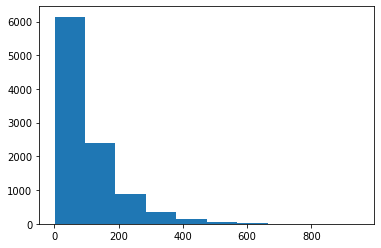

In [ ]:
plt.hist(weights_test_cases[('geometric', 1000000, 10000)][0])

In [ ]:
probabilities_test_cases[('near_1', 10000)][0]

array([0.00017853, 0.02354913, 0.11638917, ..., 0.0542856 , 0.07752462,
       0.06326628])

In [ ]:
np.savetxt("poisson.csv", weights_test_cases[('poisson', 1000000, 10000)][0], delimiter=",")

In [ ]:
2**25

33554432

In [ ]:
np.float